Importamos los paquetes.

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

Cargamos los datos necesarios.

In [2]:
demographic = pd.read_csv('../data/national-health-and-nutrition-examination-survey/demographic.csv', sep=',')
diet = pd.read_csv('../data/national-health-and-nutrition-examination-survey/diet.csv', sep=',')
examination = pd.read_csv('../data/national-health-and-nutrition-examination-survey/examination.csv', sep=',')
labs = pd.read_csv('../data/national-health-and-nutrition-examination-survey/labs.csv', sep=',')
medications = pd.read_csv('../data/national-health-and-nutrition-examination-survey/medications.csv', sep=',',
                          encoding='iso-8859-1')
questionnaire = pd.read_csv('../data/national-health-and-nutrition-examination-survey/questionnaire.csv', sep=',')

Realizamos una limpieza de los datos de medications. Nos quedamos solo con los que sean no nulos.
Agrupamos por SEQN tras descategorizar, ya que en medications aparece más de un registro por paciente, debido a que un paciente puede haber sido tratado por más de un motivo.

Para ello creamos un registro por paciente que tenga como variable cada una de las
enfermedades del conjunto de datos como variable binarizada. Seleccionamos solo las variables de interés. 

Convertimos el nombre de las columnas de medications2 a lista para poder tenerlas identificadas y poder tratarlas después.

In [3]:
medications = medications[medications.RXDRSD1.notnull()]

medications2 = pd.get_dummies(medications[['SEQN', 'RXDRSC1']]).groupby(['SEQN']).sum()
for i in medications2.columns:
    medications2.loc[medications2[i] > 1, i] = 1

medications2=medications2.reset_index()
# medications2
    
variablesMedications = medications2.columns.to_list()

Unimos los archivos.

In [4]:
df = pd.merge(demographic, examination, how='outer', on='SEQN')
df = pd.merge(df, diet, how='outer', on='SEQN')
df = pd.merge(df, labs, how='outer', on='SEQN')
df = pd.merge(df, questionnaire, how='outer', on='SEQN')
df = pd.merge(df, medications2, how='inner', on='SEQN')

Imputamos los Nan.


Se eliminan las filas y columnas que tengan todos los elementos nulos

In [5]:
df.dropna(axis=0, how='all', inplace=True)
df.dropna(axis=1, how='all', inplace=True)

Imputamos RIDAGEMN. Esta variable es la edad en meses y en pacientes mayores de 2 años no aparece este dato. 
Es una posible variable de interés para poder tener una edad más exacta.
Así que en los registros que no existan, multiplicamos la edad en años, RIDAGEYR, por 12 para obtener los meses.

In [6]:
df.RIDAGEMN = df.RIDAGEMN.replace(np.nan, df.RIDAGEYR*12)

Imputamos RIDEXAGM. Esta variable es la edad en meses en el momento del examen. Si el valor es nulo, 
lo imputamos con el valor de RIDAGEMN.

In [7]:
df.RIDEXAGM = df.RIDEXAGM.replace(np.nan, df.RIDAGEMN)

Imputamos de nan de variablesMedications como el valor que más se repite.

In [8]:
for v in variablesMedications:
    if df[v].isnull().sum() != 0:
        df[v].fillna(value=df[v].value_counts().index[0], inplace =True)

Para el resto de valores, hacemos distinción entre si la variable es numérica o categórica, para imputar por la media o por el valor más repetido repectivamente.

In [9]:
for column in df.columns:
    if df[column].isnull().sum() != 0:
        if df[column].dtype==object:
            df[column].fillna(value=df[column].value_counts().index[0],inplace =True)
        else:
            df[column].fillna(df[column].median(),inplace =True)

Hallamos la matriz de correlación.

In [10]:
matrizCorrelacion = df.corr()

Sacamos las variables que están relacionadas como aquellas cuya correlación sea mayor o igual a 0.8

In [11]:
variablesRelacionadas = list()
for i in range(len(matrizCorrelacion)):
    var1 = matrizCorrelacion.columns[i]
    for j in range(len(matrizCorrelacion)):
        var2 = matrizCorrelacion.columns[j]
        elemento = matrizCorrelacion.iloc[i,j]
        if (i<j) & (abs(elemento)>=0.8):
            l = list()
            l.append([var1, var2])
            l.append(elemento)
            variablesRelacionadas.append(l)
variablesRelacionadas

[[['RIDAGEYR', 'RIDAGEMN'], 0.9999940551689572],
 [['RIDAGEYR', 'RIDEXAGM'], 0.9999710262472322],
 [['RIDAGEMN', 'RIDEXAGM'], 0.9999710894656363],
 [['RIDRETH1', 'RIDRETH3'], 0.964629711400703],
 [['DMDHHSIZ', 'DMDFMSIZ'], 0.9391253962527536],
 [['WTINT2YR', 'WTMEC2YR'], 0.9760850763771678],
 [['INDHHIN2', 'INDFMIN2'], 0.9156842864809795],
 [['INDFMPIR', 'INDFMMPI'], 0.8735477671894537],
 [['BPXSY1', 'BPXSY2'], 0.9051119483569185],
 [['BPXSY1', 'BPXSY3'], 0.8877822089285669],
 [['BPXDI1', 'BPXDI2'], 0.8078652602599443],
 [['BPXSY2', 'BPXSY3'], 0.9354793985707626],
 [['BPXDI2', 'BPXDI3'], 0.8688796129690664],
 [['BMXWT', 'BMXBMI'], 0.8476111025441124],
 [['BMXWT', 'BMXARMC'], 0.9137446163891016],
 [['BMXWT', 'BMXWAIST'], 0.8289945865634065],
 [['BMXBMI', 'BMXARMC'], 0.8184739155144255],
 [['BMXBMI', 'BMXWAIST'], 0.8675863340983514],
 [['BMXARMC', 'BMXWAIST'], 0.8182883495432837],
 [['BMXWAIST', 'BMXSAD1'], 0.8134443383579767],
 [['BMXWAIST', 'BMXSAD2'], 0.8130006201321396],
 [['BMXWAIST

Eliminamos las variables que están relacionadas, excepto si son enfermedades.

In [12]:
for i in variablesRelacionadas:
    if (i[0][1] in df.columns) & (i[0][1] not in variablesMedications):
        df.drop([i[0][1]], axis = 1, inplace=True)

Convertimos las variables categóricas a numéricas.

In [13]:
df = pd.get_dummies(df)

Normalizamos los datos con StandardScaler()

In [14]:
scaler = StandardScaler()
dfN = scaler.fit_transform(df)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Implementamos la regla del codo para poder seleccionar visualmente cual es la mejor k para aplicar kMeans

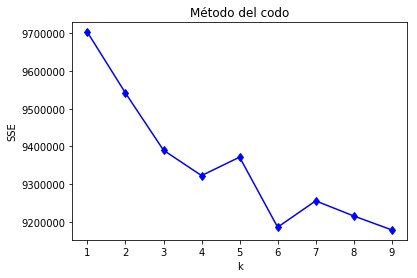

In [15]:
def regla_del_codo(k_max, datos):
    SSE = []
    for i in range(1, k_max):
        kmeans = KMeans(n_clusters = i)
        kmeans.fit(datos)
        SSE.append(kmeans.inertia_)
    plt.plot(range(1, k_max), SSE, 'bd-')
    plt.title('Método del codo')
    plt.xlabel('k')
    plt.ylabel('SSE') 
plt.show()

regla_del_codo(10, dfN)

Según la gráfica, escogemos k = 6.

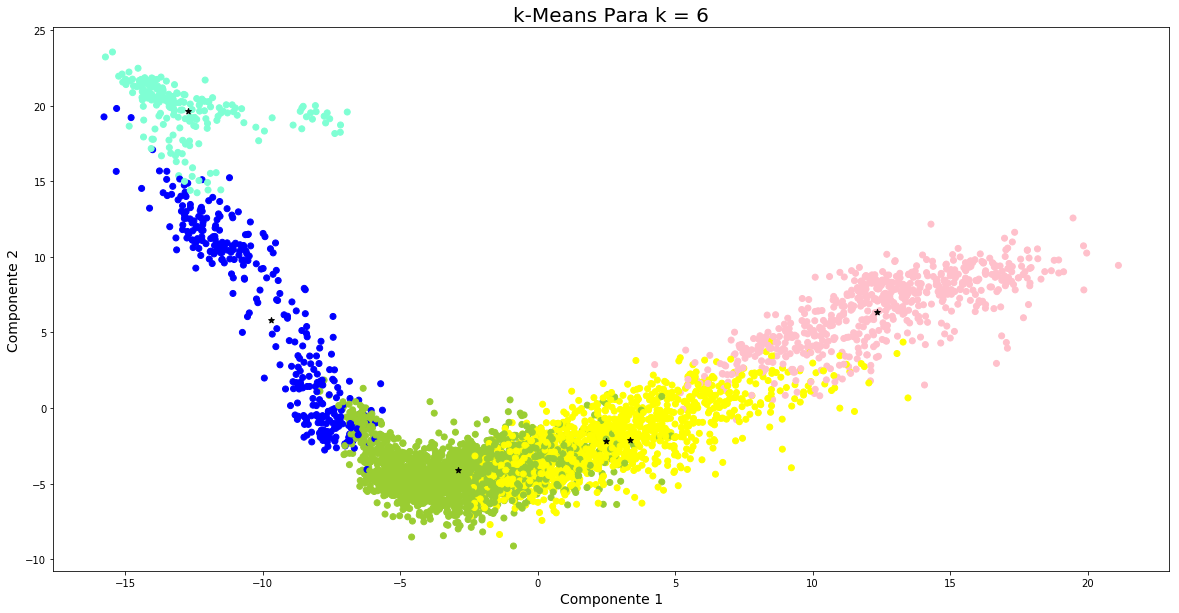

In [18]:
colores = ['r', 'yellowgreen', 'pink', 'yellow', 'b', 'aquamarine']

plt.figure(figsize=(20, 10)) 

colorCluster=[]
kmeans = KMeans(n_clusters=6).fit(dfN)
pca = PCA(n_components=2)
pca.fit(dfN)
projectedPCA = pca.fit(dfN).transform(dfN)
        
Lab = kmeans.labels_
for i in Lab:
    colorCluster.append(colores[i])
plt.scatter(projectedPCA[:, 0], projectedPCA[:, 1], c=colorCluster)
plt.scatter(pca.transform(kmeans.cluster_centers_)[:, 0], pca.transform(kmeans.cluster_centers_)[:, 1], marker='*', c='k')
plt.title('k-Means Para k = 6', fontsize=20)
plt.xlabel('Componente 1', fontsize=14)
plt.ylabel('Componente 2', fontsize=14)
plt.show()

Vamos a realizar una predicción de los clústeres con Random Forest para poder obtener que variables son las más importantes para asignar los clústeres.

In [19]:
dfN = pd.DataFrame(data=dfN, columns=df.columns)
X = dfN.copy()
y = kmeans.labels_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=158)

Para empezar, elegimos los mejores parámetros para max_depth y n_estimators con RandomizedSearchCV con validación cruzada.

In [20]:
parametrosRF = {'max_depth': range(20, 100), 'n_estimators': range(50, 200)}
RF = RandomForestClassifier()

RSRF = RandomizedSearchCV(RF, param_distributions = parametrosRF, cv = 10)

RSRF.fit(X_train, y_train)

C:\Users\Maria Jose- Javier\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'max_depth': range(20, 100), 'n_estimators': range(50, 200)},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [21]:
print('Valor óptimo para max_depth: {}'.format(RSRF.best_params_['max_depth']))
print('Valor óptimo para n_estimators: {}'.format(RSRF.best_params_['n_estimators']))

Valor óptimo para max_depth: 91
Valor óptimo para n_estimators: 136


Obtenemos el mejor modelo con los mejores parámetros obtenidos.

In [22]:
RFBestRS = RandomForestClassifier(max_depth=RSRF.best_params_['max_depth'], 
                                       n_estimators=RSRF.best_params_['n_estimators'])
RFBestRS.fit(X_train, y_train)

predsRFBestRS = RFBestRS.predict(X_test)

accuracy = np.true_divide(np.sum(predsRFBestRS == y_test), predsRFBestRS.shape[0])*100
print('Precisión en el conjunto de test: {:.2f}%'.format(accuracy))

Precisión en el conjunto de test: 94.55%


Hayamos las variables más importantes y guardamos las 50 más importantes entre todas.

In [23]:
importancias_variables = RFBestRS.feature_importances_
mejores = np.argsort(importancias_variables)[-50:][::-1]
mejoresTodas = np.argsort(importancias_variables)[::-1]

posicion=1
for variable in mejores:
    print ('La variable en {}ª posición es {}, con una importancia de {}'.format(posicion, X.iloc[:,variable].name,
                                                                                   round(importancias_variables[variable], 6)))
    posicion+=1

La variable en 1ª posición es RIDAGEYR, con una importancia de 0.016688
La variable en 2ª posición es OHX04CTC_S, con una importancia de 0.013943
La variable en 3ª posición es OHX29CTC_S, con una importancia de 0.01197
La variable en 4ª posición es OHX13CTC_S, con una importancia de 0.011789
La variable en 5ª posición es OHX20CTC_S, con una importancia de 0.011515
La variable en 6ª posición es OHX18TC, con una importancia de 0.010943
La variable en 7ª posición es OHX11CTC_P, con una importancia de 0.010511
La variable en 8ª posición es OHX23TC, con una importancia de 0.010231
La variable en 9ª posición es OHX09CTC_S, con una importancia de 0.01016
La variable en 10ª posición es OHX02CTC_U, con una importancia de 0.010122
La variable en 11ª posición es OHX02CTC_P, con una importancia de 0.010093
La variable en 12ª posición es OHX07TC, con una importancia de 0.009758
La variable en 13ª posición es OHX06TC, con una importancia de 0.009281
La variable en 14ª posición es OHX02TC, con una im

Veamos que enfermedades tienen por clústeres.

In [24]:
cluster1 = list()
cluster2 = list()
cluster3 = list()
cluster4 = list()
cluster5 = list()
cluster6 = list()

for p in range(len(Lab)):
    if Lab[p]==0:
        cluster1.append(df.iloc[p])
    elif Lab[p]==1:
        cluster2.append(df.iloc[p])
    elif Lab[p]==2:
        cluster3.append(df.iloc[p])
    elif Lab[p]==3:
        cluster4.append(df.iloc[p])
    elif Lab[p]==4:
        cluster5.append(df.iloc[p])
    elif Lab[p]==5:
        cluster6.append(df.iloc[p])

cluster1df = pd.DataFrame(data=cluster1)
cluster2df = pd.DataFrame(data=cluster2)
cluster3df = pd.DataFrame(data=cluster3)
cluster4df = pd.DataFrame(data=cluster4)
cluster5df = pd.DataFrame(data=cluster5)
cluster6df = pd.DataFrame(data=cluster6)

#Genero csv para poder visualizar todos los registros.
# cluster1df.to_csv('cluster1df.csv', index=False, header=True)
# cluster2df.to_csv('cluster2df.csv', index=False, header=True)
# cluster3df.to_csv('cluster3df.csv', index=False, header=True)
# cluster4df.to_csv('cluster4df.csv', index=False, header=True)
# cluster5df.to_csv('cluster5df.csv', index=False, header=True)
# cluster6df.to_csv('cluster6df.csv', index=False, header=True)

In [25]:
cluster1Enfdf = cluster1df[variablesMedications]
cluster2Enfdf = cluster2df[variablesMedications]
cluster3Enfdf = cluster3df[variablesMedications]
cluster4Enfdf = cluster4df[variablesMedications]
cluster5Enfdf = cluster5df[variablesMedications]
cluster6Enfdf = cluster6df[variablesMedications]


# cluster1Enfdf.to_csv('cluster1Enfdf.csv', index=False, header=True)
# cluster2Enfdf.to_csv('cluster2Enfdf.csv', index=False, header=True)
# cluster3Enfdf.to_csv('cluster3Enfdf.csv', index=False, header=True)
# cluster4Enfdf.to_csv('cluster4Enfdf.csv', index=False, header=True)
# cluster5Enfdf.to_csv('cluster5Enfdf.csv', index=False, header=True)
# cluster6Enfdf.to_csv('cluster6Enfdf.csv', index=False, header=True)

In [26]:
cluster1Enfdf.head(5)

,SEQN,RXDRSC1_A08.4,RXDRSC1_A09,RXDRSC1_A15,RXDRSC1_A15.P,RXDRSC1_A41.9,RXDRSC1_A44.9,RXDRSC1_A49.02,RXDRSC1_A49.9,RXDRSC1_A49.9P,...,RXDRSC1_Z91.030,RXDRSC1_Z94.0,RXDRSC1_Z95.0,RXDRSC1_Z95.2,RXDRSC1_Z95.5,RXDRSC1_Z95.9,RXDRSC1_Z96.64,RXDRSC1_Z96.65,RXDRSC1_Z98.84,RXDRSC1_Z99.2
1336,76911.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
cluster2Enfdf.head(5)

,SEQN,RXDRSC1_A08.4,RXDRSC1_A09,RXDRSC1_A15,RXDRSC1_A15.P,RXDRSC1_A41.9,RXDRSC1_A44.9,RXDRSC1_A49.02,RXDRSC1_A49.9,RXDRSC1_A49.9P,...,RXDRSC1_Z91.030,RXDRSC1_Z94.0,RXDRSC1_Z95.0,RXDRSC1_Z95.2,RXDRSC1_Z95.5,RXDRSC1_Z95.9,RXDRSC1_Z96.64,RXDRSC1_Z96.65,RXDRSC1_Z98.84,RXDRSC1_Z99.2
1,73558.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,73565.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,73566.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,73575.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,73600.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
cluster3Enfdf.head(5)

,SEQN,RXDRSC1_A08.4,RXDRSC1_A09,RXDRSC1_A15,RXDRSC1_A15.P,RXDRSC1_A41.9,RXDRSC1_A44.9,RXDRSC1_A49.02,RXDRSC1_A49.9,RXDRSC1_A49.9P,...,RXDRSC1_Z91.030,RXDRSC1_Z94.0,RXDRSC1_Z95.0,RXDRSC1_Z95.2,RXDRSC1_Z95.5,RXDRSC1_Z95.9,RXDRSC1_Z96.64,RXDRSC1_Z96.65,RXDRSC1_Z98.84,RXDRSC1_Z99.2
0,73557.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,73604.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,73607.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,73614.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,73615.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
cluster4Enfdf.head(5)

,SEQN,RXDRSC1_A08.4,RXDRSC1_A09,RXDRSC1_A15,RXDRSC1_A15.P,RXDRSC1_A41.9,RXDRSC1_A44.9,RXDRSC1_A49.02,RXDRSC1_A49.9,RXDRSC1_A49.9P,...,RXDRSC1_Z91.030,RXDRSC1_Z94.0,RXDRSC1_Z95.0,RXDRSC1_Z95.2,RXDRSC1_Z95.5,RXDRSC1_Z95.9,RXDRSC1_Z96.64,RXDRSC1_Z96.65,RXDRSC1_Z98.84,RXDRSC1_Z99.2
2,73559.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,73561.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,73562.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,73564.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,73571.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
cluster5Enfdf.head(5)

,SEQN,RXDRSC1_A08.4,RXDRSC1_A09,RXDRSC1_A15,RXDRSC1_A15.P,RXDRSC1_A41.9,RXDRSC1_A44.9,RXDRSC1_A49.02,RXDRSC1_A49.9,RXDRSC1_A49.9P,...,RXDRSC1_Z91.030,RXDRSC1_Z94.0,RXDRSC1_Z95.0,RXDRSC1_Z95.2,RXDRSC1_Z95.5,RXDRSC1_Z95.9,RXDRSC1_Z96.64,RXDRSC1_Z96.65,RXDRSC1_Z98.84,RXDRSC1_Z99.2
9,73572.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,73583.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,73630.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52,73680.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,73686.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
cluster6Enfdf.head(5)

,SEQN,RXDRSC1_A08.4,RXDRSC1_A09,RXDRSC1_A15,RXDRSC1_A15.P,RXDRSC1_A41.9,RXDRSC1_A44.9,RXDRSC1_A49.02,RXDRSC1_A49.9,RXDRSC1_A49.9P,...,RXDRSC1_Z91.030,RXDRSC1_Z94.0,RXDRSC1_Z95.0,RXDRSC1_Z95.2,RXDRSC1_Z95.5,RXDRSC1_Z95.9,RXDRSC1_Z96.64,RXDRSC1_Z96.65,RXDRSC1_Z98.84,RXDRSC1_Z99.2
16,73612.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,73620.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31,73635.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51,73679.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,73838.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
def contador (clusterdf):
    clusterContador = clusterdf.astype(bool).sum(axis=0).sort_values(ascending=False)
    clusterContador = clusterContador[clusterContador!=0]
    return clusterContador

In [37]:
cluster1Contador = contador(cluster1Enfdf)
cluster2Contador = contador(cluster2Enfdf)
cluster3Contador = contador(cluster3Enfdf)
cluster4Contador = contador(cluster4Enfdf)
cluster5Contador = contador(cluster5Enfdf)
cluster6Contador = contador(cluster6Enfdf)

# cluster1Contador.to_csv('cluster1Contador.csv', index=True, header=True)
# cluster2Contador.to_csv('cluster2Contador.csv', index=True, header=True)
# cluster3Contador.to_csv('cluster3Contador.csv', index=True, header=True)
# cluster4Contador.to_csv('cluster4Contador.csv', index=True, header=True)
# cluster5Contador.to_csv('cluster5Contador.csv', index=True, header=True)
# cluster6Contador.to_csv('cluster6Contador.csv', index=True, header=True)

Analicemos que tienen en común cada clúster.

Tamaño de cada cluster.

In [38]:
print('Tamaño del cluster1: {}'.format(len(cluster1)))
print('Tamaño del cluster2: {}'.format(len(cluster2)))
print('Tamaño del cluster3: {}'.format(len(cluster3)))
print('Tamaño del cluster4: {}'.format(len(cluster4)))
print('Tamaño del cluster5: {}'.format(len(cluster5)))
print('Tamaño del cluster6: {}'.format(len(cluster6)))

Tamaño del cluster1: 1
Tamaño del cluster2: 1683
Tamaño del cluster3: 611
Tamaño del cluster4: 1199
Tamaño del cluster5: 330
Tamaño del cluster6: 192


Hemos escogido $k = 6$, sin embargo en la gráfica del clustering solamente distinguimos 5. Esto es debido a que el cluster1 tiene un único registro y es el centroide del cluster, que en la representación tiene la forma de estrella en negro. Por eso no vemos ningún punto en rojo.

Hallamos los datos en su descomposición en PCA.

In [48]:
clusterPCA1=[]
clusterPCA2=[]
clusterPCA3=[]
clusterPCA4=[]
clusterPCA5=[]
clusterPCA6=[]

for p in range(len(Lab)):
    if Lab[p]==0:
        clusterPCA1.append(projectedPCA[p])
    elif Lab[p]==1:
        clusterPCA2.append(projectedPCA[p])
    elif Lab[p]==2:
        clusterPCA3.append(projectedPCA[p])
    elif Lab[p]==3:
        clusterPCA4.append(projectedPCA[p])
    elif Lab[p]==4:
        clusterPCA5.append(projectedPCA[p])
    elif Lab[p]==5:
        clusterPCA6.append(projectedPCA[p])

El elemento del cluster1 en PCA es:

In [49]:
clusterPCA1

[array([ 3.34917147, -2.08719642])]

En la gráfica podemos ver que es cercano al cluster amarillo.

In [53]:
pca.transform(kmeans.cluster_centers_)[3]

array([ 2.49604152, -2.20411391])

In [39]:
mejoresNombres = [X.iloc[:,m].name for m in mejores]
d1 = cluster1df[mejoresNombres].describe()
d2 = cluster2df[mejoresNombres].describe()
d3 = cluster3df[mejoresNombres].describe()
d4 = cluster4df[mejoresNombres].describe()
d5 = cluster5df[mejoresNombres].describe()
d6 = cluster6df[mejoresNombres].describe()

d1.to_csv('cluster1Describe.csv', index=True, header=True)
d2.to_csv('cluster2Describe.csv', index=True, header=True)
d3.to_csv('cluster3Describe.csv', index=True, header=True)
d4.to_csv('cluster4Describe.csv', index=True, header=True)
d5.to_csv('cluster5Describe.csv', index=True, header=True)
d6.to_csv('cluster6Describe.csv', index=True, header=True)

In [40]:
d1

,RIDAGEYR,OHX04CTC_S,OHX29CTC_S,OHX13CTC_S,OHX20CTC_S,OHX18TC,OHX11CTC_P,OHX23TC,OHX09CTC_S,OHX02CTC_U,...,OHX12CTC_S,SMAQUEX.x,OHX30CTC_P,OHX10CTC_S,OHX27CTC_S,OHX05TC,OHX03CTC_P,OHX13TC,OHX06CTC_P,OHX03TC
count,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
mean,56.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,0.0,2.0,0.0,1.0,1.0,4.0,0.0,4.0,0.0,4.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,56.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,0.0,2.0,0.0,1.0,1.0,4.0,0.0,4.0,0.0,4.0
25%,56.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,0.0,2.0,0.0,1.0,1.0,4.0,0.0,4.0,0.0,4.0
50%,56.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,0.0,2.0,0.0,1.0,1.0,4.0,0.0,4.0,0.0,4.0
75%,56.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,0.0,2.0,0.0,1.0,1.0,4.0,0.0,4.0,0.0,4.0
max,56.0,0.0,0.0,0.0,1.0,2.0,0.0,2.0,1.0,0.0,...,0.0,2.0,0.0,1.0,1.0,4.0,0.0,4.0,0.0,4.0


In [41]:
d2

,RIDAGEYR,OHX04CTC_S,OHX29CTC_S,OHX13CTC_S,OHX20CTC_S,OHX18TC,OHX11CTC_P,OHX23TC,OHX09CTC_S,OHX02CTC_U,...,OHX12CTC_S,SMAQUEX.x,OHX30CTC_P,OHX10CTC_S,OHX27CTC_S,OHX05TC,OHX03CTC_P,OHX13TC,OHX06CTC_P,OHX03TC
count,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,...,1683.00000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000,1683.000000
mean,40.463458,0.787879,0.816399,0.764706,0.816993,2.168746,0.001783,2.008318,0.897802,0.000594,...,0.78372,1.995247,0.004159,0.906120,0.986334,2.164587,0.004753,2.086750,0.001188,2.141414
std,18.436130,0.408932,0.387273,0.424309,0.386787,0.568744,0.042195,0.128754,0.302999,0.024376,...,0.41183,0.316004,0.064377,0.291748,0.116135,0.554631,0.068801,0.439797,0.034462,0.536616
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000,...,0.00000,1.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,2.000000
25%,27.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,2.000000,1.000000,0.000000,...,1.00000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,2.000000,0.000000,2.000000
50%,41.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,2.000000,1.000000,0.000000,...,1.00000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,2.000000,0.000000,2.000000
75%,53.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,2.000000,1.000000,0.000000,...,1.00000,2.000000,0.000000,1.000000,1.000000,2.000000,0.000000,2.000000,0.000000,2.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,4.000000,1.000000,1.000000,...,1.00000,3.000000,1.000000,1.000000,1.000000,5.000000,1.000000,5.000000,1.000000,5.000000


In [42]:
d3

,RIDAGEYR,OHX04CTC_S,OHX29CTC_S,OHX13CTC_S,OHX20CTC_S,OHX18TC,OHX11CTC_P,OHX23TC,OHX09CTC_S,OHX02CTC_U,...,OHX12CTC_S,SMAQUEX.x,OHX30CTC_P,OHX10CTC_S,OHX27CTC_S,OHX05TC,OHX03CTC_P,OHX13TC,OHX06CTC_P,OHX03TC
count,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.0,...,611.000000,611.0,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000,611.000000
mean,66.806874,0.014730,0.047463,0.009820,0.054010,3.914894,0.772504,3.448445,0.027823,0.0,...,0.016367,2.0,0.672668,0.022913,0.212766,3.932897,0.828151,3.924714,0.793781,3.967267
std,11.455488,0.120569,0.212802,0.098689,0.226222,0.427679,0.419559,0.931354,0.164601,0.0,...,0.126985,0.0,0.469624,0.149750,0.409599,0.417347,0.377559,0.405973,0.404921,0.311909
min,30.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.0,...,0.000000,2.0,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,2.000000
25%,60.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,2.000000,0.000000,0.0,...,0.000000,2.0,0.000000,0.000000,0.000000,4.000000,1.000000,4.000000,1.000000,4.000000
50%,69.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.0,...,0.000000,2.0,1.000000,0.000000,0.000000,4.000000,1.000000,4.000000,1.000000,4.000000
75%,76.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,4.000000,0.000000,0.0,...,0.000000,2.0,1.000000,0.000000,0.000000,4.000000,1.000000,4.000000,1.000000,4.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,5.000000,1.000000,0.0,...,1.000000,2.0,1.000000,1.000000,1.000000,5.000000,1.000000,5.000000,1.000000,5.000000


In [43]:
d4

,RIDAGEYR,OHX04CTC_S,OHX29CTC_S,OHX13CTC_S,OHX20CTC_S,OHX18TC,OHX11CTC_P,OHX23TC,OHX09CTC_S,OHX02CTC_U,...,OHX12CTC_S,SMAQUEX.x,OHX30CTC_P,OHX10CTC_S,OHX27CTC_S,OHX05TC,OHX03CTC_P,OHX13TC,OHX06CTC_P,OHX03TC
count,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.0,...,1199.000000,1199.0,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000,1199.000000
mean,64.572977,0.166806,0.253545,0.177648,0.254379,2.908257,0.012510,2.083403,0.446205,0.0,...,0.215179,2.0,0.048374,0.440367,0.851543,2.612177,0.058382,2.637198,0.015013,2.754796
std,11.175836,0.372958,0.435221,0.382376,0.435693,1.022252,0.111195,0.399979,0.497305,0.0,...,0.411118,0.0,0.214644,0.496638,0.355701,0.978339,0.234562,0.985361,0.121653,1.011581
min,22.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.0,...,0.000000,2.0,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,2.000000
25%,57.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.0,...,0.000000,2.0,0.000000,0.000000,1.000000,2.000000,0.000000,2.000000,0.000000,2.000000
50%,65.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.0,...,0.000000,2.0,0.000000,0.000000,1.000000,2.000000,0.000000,2.000000,0.000000,2.000000
75%,74.000000,0.000000,1.000000,0.000000,1.000000,4.000000,0.000000,2.000000,1.000000,0.0,...,0.000000,2.0,0.000000,1.000000,1.000000,4.000000,0.000000,4.000000,0.000000,4.000000
max,80.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,4.000000,1.000000,0.0,...,1.000000,2.0,1.000000,1.000000,1.000000,5.000000,1.000000,5.000000,1.000000,5.000000


In [44]:
d5

,RIDAGEYR,OHX04CTC_S,OHX29CTC_S,OHX13CTC_S,OHX20CTC_S,OHX18TC,OHX11CTC_P,OHX23TC,OHX09CTC_S,OHX02CTC_U,...,OHX12CTC_S,SMAQUEX.x,OHX30CTC_P,OHX10CTC_S,OHX27CTC_S,OHX05TC,OHX03CTC_P,OHX13TC,OHX06CTC_P,OHX03TC
count,330.000000,330.000000,330.000000,330.000000,330.000000,330.000000,330.0,330.000000,330.000000,330.000000,...,330.000000,330.000000,330.0,330.000000,330.000000,330.000000,330.0,330.000000,330.0,330.000000
mean,10.503030,0.463636,0.478788,0.457576,0.451515,3.115152,0.0,1.987879,0.942424,0.630303,...,0.536364,2.290909,0.0,0.827273,0.551515,1.639394,0.0,1.521212,0.0,2.006061
std,2.616581,0.499433,0.500308,0.498953,0.498399,0.994856,0.0,0.220193,0.233293,0.483456,...,0.499433,0.958204,0.0,0.378585,0.498094,0.628811,0.0,0.568557,0.0,0.110096
min,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,1.000000,0.000000,0.000000,...,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,0.0,1.000000,0.0,2.000000
25%,8.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,2.000000,1.000000,0.000000,...,0.000000,1.000000,0.0,1.000000,0.000000,1.000000,0.0,1.000000,0.0,2.000000
50%,10.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.0,2.000000,1.000000,1.000000,...,1.000000,3.000000,0.0,1.000000,1.000000,2.000000,0.0,1.000000,0.0,2.000000
75%,12.000000,1.000000,1.000000,1.000000,1.000000,4.000000,0.0,2.000000,1.000000,1.000000,...,1.000000,3.000000,0.0,1.000000,1.000000,2.000000,0.0,2.000000,0.0,2.000000
max,16.000000,1.000000,1.000000,1.000000,1.000000,4.000000,0.0,4.000000,1.000000,1.000000,...,1.000000,3.000000,0.0,1.000000,1.000000,4.000000,0.0,4.000000,0.0,4.000000


In [45]:
d6

,RIDAGEYR,OHX04CTC_S,OHX29CTC_S,OHX13CTC_S,OHX20CTC_S,OHX18TC,OHX11CTC_P,OHX23TC,OHX09CTC_S,OHX02CTC_U,...,OHX12CTC_S,SMAQUEX.x,OHX30CTC_P,OHX10CTC_S,OHX27CTC_S,OHX05TC,OHX03CTC_P,OHX13TC,OHX06CTC_P,OHX03TC
count,192.00000,192.0,192.0,192.0,192.0,192.0,192.0,192.000000,192.000000,192.0,...,192.0,192.0,192.0,192.0,192.0,192.000000,192.0,192.000000,192.0,192.000000
mean,3.50000,0.0,0.0,0.0,0.0,4.0,0.0,1.145833,0.020833,1.0,...,0.0,3.0,0.0,0.0,0.0,1.281250,0.0,1.609375,0.0,3.750000
std,1.84192,0.0,0.0,0.0,0.0,0.0,0.0,0.613618,0.143200,0.0,...,0.0,0.0,0.0,0.0,0.0,0.876728,0.0,1.210130,0.0,0.663167
min,1.00000,0.0,0.0,0.0,0.0,4.0,0.0,1.000000,0.000000,1.0,...,0.0,3.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,2.000000
25%,2.00000,0.0,0.0,0.0,0.0,4.0,0.0,1.000000,0.000000,1.0,...,0.0,3.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,4.000000
50%,3.00000,0.0,0.0,0.0,0.0,4.0,0.0,1.000000,0.000000,1.0,...,0.0,3.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,4.000000
75%,5.00000,0.0,0.0,0.0,0.0,4.0,0.0,1.000000,0.000000,1.0,...,0.0,3.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.0,4.000000
max,8.00000,0.0,0.0,0.0,0.0,4.0,0.0,4.000000,1.000000,1.0,...,0.0,3.0,0.0,0.0,0.0,4.000000,0.0,4.000000,0.0,4.000000
